# Agent interaction analysis
## Step by step data extraction

In [1]:
# Imports
import glob
import pandas as pd
import torch
from pathlib import Path
from matplotlib import pyplot as plt
from egg.zoo.pop.scripts.analysis_tools.analysis import interaction_to_dataframe, name_to_idx, extract_name
import seaborn as sns

# used in a later part of the script :
import numpy as np
import scipy

# diagnostic classifier
import egg.zoo.pop.scripts.analysis_tools.diagnostic_classifier as dc

# clustering
from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# clustered images observation
from egg.zoo.pop.data import get_dataloader
import numpy as np
import random
from matplotlib.pyplot import cm

# PCA
from sklearn.decomposition import PCA
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)



In [82]:
# fill the interaction_files table with paths of interaction files to analyse
# interaction_files = glob.glob("/home/mmahaut/projects/exps/tmlr/v64_com_sender_rep/imagenet*")
# pop_interaction_files = glob.glob("/home/mmahaut/projects/exps/tmlr/places205/places205*None*")
interaction_files = glob.glob("/home/mmahaut/projects/exps/tmlr/seq_augm/*resize*.pth")
#interaction_files.append("/homedtcl/mmahaut/projects/experiments/int_fuller/None['vgg11','vit','resnet152', 'inception','swin','dino']['vgg11','vit','resnet152', 'inception','swin','dino']")
pops = []
for i,f in enumerate(interaction_files):
    if "'vit'" in f and "'inception'" in f and "'swin'" in f:
        pops.append(i)
    else:
        print(f)
print(pops, len(interaction_files))

pop_interaction_files=[]
for i in pops:
    pop_interaction_files.append(interaction_files[i])
    
interaction_files = [i for i in range(len(interaction_files)) if i not in pops]
print(len(interaction_files), "files", len(pop_interaction_files), "popfiles")

    
# load files, then put them in easily handled dataframes
inters = [torch.load(file) for file in interaction_files]
for inter in inters:
    inter.labels=inter.labels.reshape(-1)
df_inters = [interaction_to_dataframe(inter) for inter in inters]

inters = [torch.load(file) for file in pop_interaction_files]
for inter in inters:
    inter.labels=inter.labels.reshape(-1)
pop_df_inters = [interaction_to_dataframe(inter) for inter in inters] 
print("available information in dataframe : \n", pop_df_inters[0].columns)
interaction_files=pop_interaction_files

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 10
0 files 10 popfiles
available information in dataframe : 
 Index(['labels', 'sender_idx', 'recv_idx', 'loss_idx', 'batch_number',
       'receiver_output'],
      dtype='object')


### A few numbers to explain the data
#### Looking at accuracy and its significance

In [83]:
# check performance scores of all loaded files :
def get_accs(df_inters, augm="None"):
    indexed_printing = True # UI : if set to false, file names are used instead of indices
    hom_acc = []
    hom_acc = []
    het_acc = []
    pop_acc = []
    for i, df_inter in enumerate(df_inters):
        acc = (df_inter.batch_number % 64 == df_inter.receiver_output).mean().item()
        # Details out population
        if (df_inter.sender_idx.nunique() != 1 and df_inter.recv_idx.nunique() != 1) or "'vit', 'inception'" in interaction_files[i]:
#             print(f"---------- {interaction_files[i]} ----------")
#             print(f"average accuracy = {acc}")
#             print(f"sd = {(df_inter.batch_number % 64 == df_inter.receiver_output).std().item()}")
#             print(f"{df_inter.sender_idx.nunique()} sender, {df_inter.recv_idx.nunique()} receivers")
            for sidx in range(df_inter.sender_idx.nunique()):
                for ridx in range(df_inter.recv_idx.nunique()):
    #                 select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]
                    select_inters = df_inter[df_inter.sender_idx == sidx][df_inter[df_inter.sender_idx == sidx].recv_idx == ridx]
                    _acc = (select_inters.batch_number % 64 == select_inters.receiver_output).mean()
                    pop_acc.append(_acc)
#                     print(f"{sidx} - {ridx} accuracy = {_acc}")
        else :
            #single agent simple version (clearest version temporarly broken, printing file names)
            #_indexes = [name_to_idx(name) for name in extract_name(interaction_files[i])]
            #print(f"{_indexes[0]} - {_indexes[1]} accuracy = {acc}" if indexed_printing else f"{interaction_files[i]}  accuracy = {acc}")
            sender = interaction_files[i][:-4].split(augm)[1][1:].split("][")[0]
            receiver = interaction_files[i][:-4].split(augm)[1][1:].split("][")[1][:-1]
#             print(sender, receiver, acc)
            if sender == receiver:
                hom_acc.append(acc)
            else:
                het_acc.append(acc)
#     print("homogeneous: ",sum(hom_acc)/len(hom_acc), np.std(hom_acc))
#     print("heterogeneous: ",sum(het_acc)/len(het_acc), np.std(het_acc))
#     print("pop", pop_acc)
    return(hom_acc, het_acc, pop_acc)
_,_,accs=get_accs(pop_df_inters)
accs=np.array(accs)
accs = accs[~np.isnan(accs)]
print("all_accs_mean:",sum(accs)/len(accs), "std_dev:", np.std(accs), "portion of data:", len(accs)/(64*len(interaction_files)))

all_accs_mean: 0.9030471533496878 std_dev: 0.06237063134467244 portion of data: 0.6859375


In [14]:
# still unstable : same as previous but with a heatmap
# unstable because it requires that all one on one and a population be used
models = ['vgg','vit','resnet', 'incep','swin','dino','r-coco']
one_one_accs = torch.empty((len(models),len(models)))
_accs = torch.empty((len(models),len(models)))
for i, df_inter in enumerate(pop_df_inters):
    acc = (df_inter.batch_number % 64 == df_inter.receiver_output).mean().item()
    if df_inter.sender_idx.nunique() != 1 or df_inter.recv_idx.nunique() != 1:
        print(f"---------- {interaction_files[i]} ----------")
        print(f"average accuracy = {acc}")
        print(f"{df_inter.sender_idx.nunique()} sender, {df_inter.recv_idx.nunique()} receivers")
        _accs = torch.empty((df_inter.sender_idx.nunique(),df_inter.recv_idx.nunique()))
        for sidx in range(df_inter.sender_idx.nunique()):
            for ridx in range(df_inter.recv_idx.nunique()):
#                 select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]
                select_inters = df_inter[df_inter.sender_idx == sidx][df_inter[df_inter.sender_idx == sidx].recv_idx == ridx]
                _acc = (select_inters.batch_number % 64 == select_inters.receiver_output).mean()
                _accs[sidx][ridx] = _acc
                
    else :
        _indexes = [name_to_idx(name) for name in extract_name(interaction_files[i].replace(".pth",""))]
        #assert one_one_accs[_indexes[0]][_indexes[1]] == 0, f"tried to put value in non-empty slot : got {one_one_accs[_indexes[0]][_indexes[1]]}"
        one_one_accs[_indexes[0]][_indexes[1]] = acc
# for i, df_inter in enumerate(df_inters):
#     acc = (df_inter.batch_number % 64 == df_inter.receiver_output).mean().item()
#     _indexes = [name_to_idx(name) for name in extract_name(interaction_files[i])]
#     #assert one_one_accs[_indexes[0]][_indexes[1]] == 0, f"tried to put value in non-empty slot : got {one_one_accs[_indexes[0]][_indexes[1]]}"
#     _accs[_indexes[0]][_indexes[1]] = acc
_accs[-1,-1]=.99

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

df1 = pd.DataFrame(one_one_accs, columns=models, index=models)
df2 = pd.DataFrame(_accs, columns=models, index=models)

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)

sns.heatmap(df1, cmap="crest", ax=ax1, vmax=1, vmin = 0.1, cbar=True, annot=True)
sns.heatmap(df2, cmap="crest", ax=ax2, vmax=1, vmin = 0.9, cbar=True, annot=True)


ax2.yaxis.tick_right()
ax1.set_title('one on one')
#ax2.set_title('population testing accuracy')
ax2.set_title('population')

fig.subplots_adjust(wspace=0.001)
plt.show()


df_heatmap = pd.DataFrame(one_one_accs, columns=models, index=models)

---------- /home/mmahaut/projects/exps/tmlr/seq_augm/imagenet_valcontinuous64resize['swin', 'vgg11', 'resnet152', 'virtex', 'inception', 'vit', 'vit_clip', 'dino']['resnet152', 'virtex', 'vit', 'vit_clip', 'vgg11', 'dino', 'inception', 'swin'].pth ----------
average accuracy = 0.8869032557354926
3 sender, 8 receivers
---------- /home/mmahaut/projects/exps/tmlr/seq_augm/imagenet_valcontinuous64color_jitter['resnet152', 'vit', 'swin', 'vit_clip', 'dino', 'vgg11', 'inception', 'virtex']['inception', 'dino', 'vgg11', 'vit_clip', 'resnet152', 'virtex', 'swin', 'vit'].pth ----------
average accuracy = 0.9250600961538461
2 sender, 8 receivers
---------- /home/mmahaut/projects/exps/tmlr/seq_augm/imagenet_valcontinuous64grayscale['swin', 'vgg11', 'resnet152', 'virtex', 'inception', 'vit', 'vit_clip', 'dino']['resnet152', 'virtex', 'vit', 'vit_clip', 'vgg11', 'dino', 'inception', 'swin'].pth ----------
average accuracy = 0.9612580128205128
3 sender, 8 receivers
---------- /home/mmahaut/projects/

---------- /home/mmahaut/projects/exps/tmlr/seq_augm/imagenet_valcontinuous64gaussian_blur['vit', 'dino', 'vit_clip', 'swin', 'inception', 'vgg11', 'resnet152', 'virtex']['swin', 'resnet152', 'inception', 'vit', 'vgg11', 'virtex', 'vit_clip', 'dino'].pth ----------
average accuracy = 0.6229467147435898
2 sender, 8 receivers
---------- /home/mmahaut/projects/exps/tmlr/seq_augm/imagenet_valcontinuous64color_jitter['dino', 'resnet152', 'swin', 'inception', 'vgg11', 'virtex', 'vit', 'vit_clip']['vit', 'vgg11', 'dino', 'inception', 'swin', 'vit_clip', 'resnet152', 'virtex'].pth ----------
average accuracy = 0.9552556818181818
2 sender, 8 receivers
---------- /home/mmahaut/projects/exps/tmlr/seq_augm/imagenet_valcontinuous64grayscale['dino', 'resnet152', 'swin', 'inception', 'vgg11', 'virtex', 'vit', 'vit_clip']['vit', 'vgg11', 'dino', 'inception', 'swin', 'vit_clip', 'resnet152', 'virtex'].pth ----------
average accuracy = 0.9846707112332113
3 sender, 8 receivers
---------- /home/mmahaut/pr

ValueError: Shape of passed values is (3, 8), indices imply (7, 7)

In [31]:
# # plt.clear()
# print(df2)
sns.set_theme(rc={'figure.figsize':(6,5.2)})
cols=['vgg','incep','resnet', 'r-coco','swin','vit','dino']
df2=df2.reindex(cols)
sns.heatmap(df2[cols], cmap="crest", vmax=1, vmin = 0.9, cbar=True, annot=True).set(title="Population Accuracies")
# sns.heatmap(_accs,)

NameError: name 'df2' is not defined

In [71]:
# !! WARNING This cell is only relevant if both a population and corresponding one-on-one are loaded
# Is there a significant difference between one on one and population communication ?
# Is there a difference between homogeneous and heterogeneous populations ?

# get 1 - 1 accuracies
a = []
rs_pairs = []
pop_inters = pd.DataFrame()
for i, df_inter in enumerate(df_inters):
    if df_inter.sender_idx.nunique() == 1 and df_inter.recv_idx.nunique() == 1:
        # get index
        sidx = name_to_idx(extract_name(interaction_files[i])[0])
        ridx = name_to_idx(extract_name(interaction_files[i])[1])
        rs_pairs.append((sidx, ridx))
        
        _a_acc = (df_inter.batch_number % 64 == df_inter.receiver_output).mean().item()
        a.append(_a_acc)
    else :
        # use this pass to get the population interaction file from the bunch
        pop_inters = df_inter

b=[]
# get pop accuracy
for sidx, ridx in rs_pairs:
#     selected_inters = pop_inters[pop_inters.sender_idx == sidx][pop_inters.recv_idx == ridx]
    selected_inters = pop_inters[pop_inters.sender_idx == sidx][pop_inters[pop_inters.sender_idx == sidx].recv_idx == ridx]
    _b_acc = (selected_inters.batch_number % 64 == selected_inters.receiver_output).mean()
    b.append(_b_acc)


a = [_val for i,_val in enumerate(a) if not pd.isnull(b)[i]]
b = [_val for _val in b if not pd.isnull(_val)]
print(a,b)
print("PASSED 3")

# paired wilcoxon : no proof of normal distribution
print("Wilcoxon :", scipy.stats.wilcoxon(a,b)) # a is less than b
print("Wilcoxon (a<b):", scipy.stats.wilcoxon(a,b, alternative="less")) # a is less than b

# paired fischer : normal distribution
print("Fischer :", scipy.stats.ttest_rel(a,b))
print("Fischer (a<b):", scipy.stats.ttest_rel(a,b, alternative="less"))

[0.9887820512820513, 0.9985977564102564, 0.9701522435897436, 0.9833733974358975, 0.9993990384615384, 0.9939903846153846, 0.9495192307692307, 0.9963942307692307, 0.9817708333333334, 0.9997996794871795, 0.9989983974358975, 0.9997996794871795, 0.9965945512820513, 0.985176282051282, 1.0, 0.9997996794871795, 0.9915865384615384, 0.9961939102564102, 0.9973958333333334, 0.9645432692307693, 0.9983974358974359, 0.999198717948718, 0.9945913461538461, 1.0, 0.9861778846153846, 0.9987980769230769, 0.9997996794871795, 0.9995993589743589, 1.0, 0.9989983974358975, 0.9995993589743589, 0.9841746794871795, 0.9861778846153846, 0.999198717948718, 0.9983974358974359, 0.9997996794871795, 0.9995993589743589, 0.9979967948717948, 0.999198717948718, 0.999198717948718, 0.9921875, 1.0, 0.9877804487179487, 0.9723557692307693, 0.9881810897435898, 0.9997996794871795, 0.9981971153846154, 0.9979967948717948] [0.968127667140825, 0.9884423897581792, 0.984997332859175, 0.9908205903271693, 0.9950213371266002, 0.967149715504

#### Analysis of message differences

In [15]:
def euler_distance(a,b):
    # euler distance
    s = (a.loc[:,a.columns.str.contains('dim')].reset_index() - b.loc[:,b.columns.str.contains('dim')].reset_index())**2
    return s.sum(axis=1)**0.5

def cosine_distance(a,b):
    # cosine distance
    print(a.keys())
    print(a["batch_number"], b["batch_number"])
    a = a.set_index("batch_number")
    b = b.set_index("batch_number")
    cos_dis = []
    a_dim = a.loc[:,a.columns.str.contains('dim')].values[:,1:]
    b_dim = b.loc[:,b.columns.str.contains('dim')].values[:,1:]
    # print(a_dim.shape, b_dim.shape)
    # print([key for key in a_dim.columns if key in b_dim.columns])
    # print("test", a_dim.sample(3).values)
    cos_dis = 1 - torch.nn.functional.cosine_similarity(torch.Tensor(a_dim), torch.Tensor(b_dim))
    print(cos_dis)

    return cos_dis

In [38]:
# max_len=min(len(pop_df_inters[0]),len(pop_df_inters[0]))
dist=cosine_distance(pop_df_inters[0][:max_len],pop_df_inters[0][:max_len])
# print(dist.mean())
# pop_df_inters[0]["receiver_output"]

Index(['labels', 'sender_idx', 'recv_idx', 'loss_idx', 'batch_number',
       'receiver_output'],
      dtype='object')
0            0
1            1
2            2
3            3
4            4
          ... 
134779    4987
134780    4988
134781    4989
134782    4990
134783    4991
Name: batch_number, Length: 134784, dtype: int32 0            0
1            1
2            2
3            3
4            4
          ... 
134779    4987
134780    4988
134781    4989
134782    4990
134783    4991
Name: batch_number, Length: 134784, dtype: int32
tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [73]:
pop_idx = len(df_inters) -1
archs = ['vit', 'inception', 'resnet152', 'vgg11', 'dino', 'swin', 'virtex']
df_pop = pdf_inters[pop_idx]
df_ones = df_inters[:pop_idx]
_dists = []
# for i in range(len(df_ones)):
#     sidx = i%7
#     ridx = i//7
#     _pop = df_pop[df_pop.sender_idx == sidx][df_pop[df_pop.sender_idx == sidx].recv_idx == ridx]
#     _d = cosine_distance(
#         _pop,
#         df_ones[i]).numpy()
#     _dists.append(_d)
# all_dist = np.concatenate(_dists)
all_dist = np.concatenate([
    cosine_distance(
        df_pop[len(df_ones[i])*i:len(df_ones[i])*(i+1)],
        df_ones[i]).numpy() for i in range(len(df_ones))
])

all_indexes = np.array([
    [
        names
        for names in extract_name(interaction_files[i])
    ] for i in range(len(df_inters)) if i!=len(df_inters) -1
])

# sub optimal but then again it works, and its 1:10am
all_indexes2=[[],[]]
all_indexes2[0] = np.concatenate([[name] * len(df_ones[0]) for name in all_indexes.T[0]])
all_indexes2[1] = np.concatenate([[name] * len(df_ones[1]) for name in all_indexes.T[1]])

print(len(all_indexes.T[0]), len(all_dist))
print(len(all_dist),len(all_indexes2[0]),len(all_indexes2[1]))
inter_distances = pd.DataFrame({"distance":all_dist, "idx1":all_indexes2[0][:len(all_dist)], "idx2":all_indexes2[1][:len(all_dist)],"Message distance between senders from :":"One from each"})
sns.boxplot(y=inter_distances.distance,x=inter_distances.idx1, hue=inter_distances.idx2)

Index(['labels', 'sender_idx', 'recv_idx', 'loss_idx', 'batch_number',
       'receiver_output'],
      dtype='object')
0          0
1          1
2          2
3          3
4          4
        ... 
4987    4987
4988    4988
4989    4989
4990    4990
4991    4991
Name: batch_number, Length: 4992, dtype: int32 0          0
1          1
2          2
3          3
4          4
        ... 
4987    4987
4988    4988
4989    4989
4990    4990
4991    4991
Name: batch_number, Length: 4992, dtype: int32


RuntimeError: The size of tensor a (0) must match the size of tensor b (63) at non-singleton dimension 1

In [21]:
def name_to_idx(name):
    """
    Function to convert a name to the vision-module index
    """
    names = ['vit', 'inception', 'resnet152', 'vgg11', 'dino', 'swin', 'virtex']
    assert name in names, f"{name} is not a valid vision-module name"
    return names.index(name)

In [23]:
df_ones_distances = pd.DataFrame(columns=["distance","idx1","idx2"])
arch_names = ['vit', 'inception', 'resnet152', 'vgg11', 'dino', 'swin', 'virtex']

for idx1 in range(7):
    for idx2 in range(7):
        for i,f in enumerate(interaction_files):
            if i != pop_idx:
                if name_to_idx(extract_name(f)[0]) == idx1:
                    a = df_inters[i]
                    break
                elif name_to_idx(extract_name(f)[1]) == idx2:
                    b = df_inters[i]
                    break
        if idx1 != idx2 and not (len(a) == 0 or len(b) == 0):
            _dist=cosine_distance(a,b)
            _new_df_dist = pd.DataFrame({"distance":_dist, "idx1":arch_names[idx1], "idx2":arch_names[idx2],"Message distance between senders from :":"One-on-one"})
            df_ones_distances = pd.concat([df_ones_distances,_new_df_dist])
            

sns.boxplot(y=df_ones_distances.distance,x=df_ones_distances.idx1, hue=df_ones_distances.idx2)
# plt.ylim(0, 2e-7) # TODO : deal with the scales
plt.show()

AssertionError: swin, vgg11, resnet152, virtex, inception, vit, vit_clip, dino is not a valid vision-module name

In [19]:
# given the same image, how different are the messages given by different senders
arch_names = ['vit', 'inception', 'resnet152', 'vgg11', 'dino', 'swin', 'virtex']
df_distances = pd.DataFrame(columns=["distance","idx1","idx2"])
df_inter_one = pd.DataFrame()
print(interaction_files[-1])
# display distances
for i,df_inter in enumerate(df_inters[-1:]):
    # am I in the single agent case ?
    if df_inter.recv_idx.nunique() == 1 and df_inter.sender_idx.nunique() == 1:
        pass
    # am I in the multi-agent case ?
    else:
        heatmap = np.zeros((df_inter.sender_idx.nunique(), df_inter.recv_idx.nunique()))
        for idx1 in range(df_inter.sender_idx.nunique()):
            for idx2 in range(df_inter.recv_idx.nunique()):
                a = df_inter[df_inter.sender_idx == idx1]
                b = df_inter[df_inter.sender_idx == idx2]
                print(len(a),len(b))
                _limit = min(len(a),len(b))
                a=a[:_limit]
                b=b[:_limit]

                if idx1 != idx2 and not (len(a) == 0 or  len(b) == 0):
                    _dist=cosine_distance(a,b)
                    _new_df_dist = pd.DataFrame({"distance":_dist, "idx1":arch_names[idx1], "idx2":arch_names[idx2],"Message distance between senders from :":"Population"})
                    df_distances = pd.concat([df_distances,_new_df_dist])
                    heatmap[idx1,idx2] = _dist.mean()
            

sns.boxplot(y=df_distances.distance,x=df_distances.idx1, hue=df_distances.idx2)
# plt.ylim(0, 2e-7) # TODO : deal with the scales
plt.show()

df_heatmap = pd.DataFrame(heatmap, columns=arch_names, index=arch_names)
# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    df_heatmap,
    cmap='OrRd',
    linewidth=1,
    annot=True
)

/home/mmahaut/projects/exps/tmlr/seq_augm/imagenet_valcontinuous64resize['resnet152', 'vit', 'swin', 'vit_clip', 'dino', 'vgg11', 'inception', 'virtex']['inception', 'dino', 'vgg11', 'vit_clip', 'resnet152', 'virtex', 'swin', 'vit'].pth


ValueError: min() arg is an empty sequence

       labels  sender_idx  recv_idx  loss_idx  batch_number  receiver_output
18175     170           2         3         0         18175               63
22151     108           2         5         0         22151                7
44063     941           2         4         0         44063               31
37018     959           2         3         0         37018               26
27103     526           2         4         0         27103               31
...       ...         ...       ...       ...           ...              ...
39240     292           2         0         0         39240                8
26993     811           2         1         0         26993               49
5976      184           2         6         0          5976               24
41591      55           2         5         0         41591               55
33969     135           2         1         0         33969               49

[314944 rows x 6 columns]        labels  sender_idx  recv_idx  loss_idx  ba

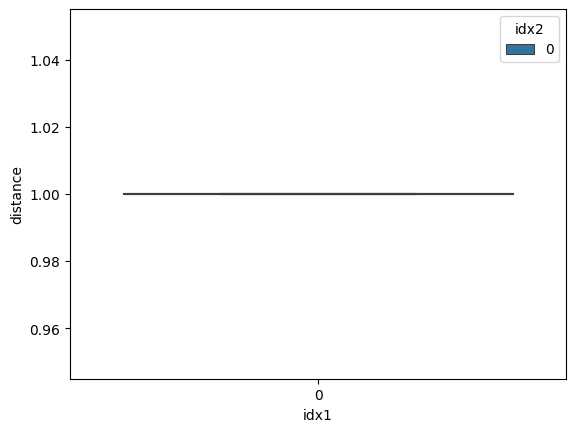

In [92]:
pop_idx = -1 #index of population in df_inters
# baseline with shuffling to make sure that that we're not comparing the same images necesseraly
df_random = pd.DataFrame(columns=["distance","idx1","idx2"])

a = df_inters[pop_idx][df_inters[pop_idx].sender_idx == 2].sample(frac=1)
b = df_inters[pop_idx][df_inters[pop_idx].sender_idx == 3].sample(frac=1)
print(a,b)
if not (len(a) == 0 or  len(b) == 0):
    _dist=cosine_distance(a,b)
    _new_df_dist = pd.DataFrame({"distance":_dist, "idx1":0, "idx2":0, "Message distance between senders from :":"Non-matching"})
    df_random = pd.concat([df_random,_new_df_dist])

# a = df_inters[pop_idx][df_inters[pop_idx].sender_idx == 0]
# b = df_inters[pop_idx][df_inters[pop_idx].sender_idx == 2]
# if not (len(a) == 0 or  len(b) == 0):
#     _dist=cosine_distance(a,b)
#     _new_df_dist = pd.DataFrame({"distance":_dist, "idx1":0, "idx2":2})
#     df_random = pd.concat([df_random,_new_df_dist])
if(len(df_random.distance)!=0):
    sns.boxplot(y=df_random.distance,x=df_random.idx1, hue=df_random.idx2)
    # plt.ylim(0, 2e-7) # TODO : deal with the scales
    plt.show()

<Axes: xlabel='Message distance between senders from :', ylabel='Distance'>

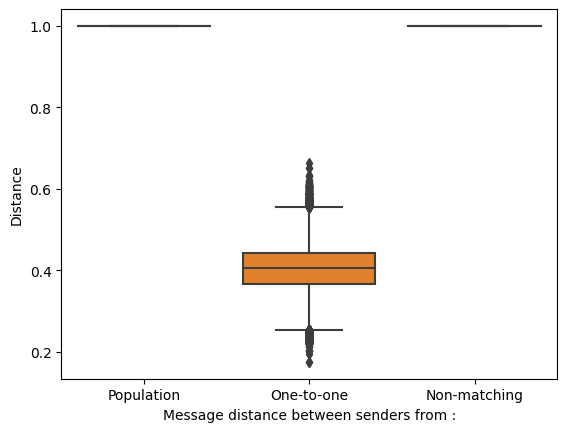

In [78]:
df_all = pd.concat([df_distances,df_ones_distances,inter_distances, df_random])
df_all = df_all.rename({'distance': 'Distance'}, axis='columns')
df_all["Message distance between senders from :"].replace(["One-on-one"],["One-to-one"], inplace=True)

sns.boxplot(df_all[df_all["Message distance between senders from :"] != "One from each"], y="Distance",x="Message distance between senders from :")


In [79]:
from torch import tensor
t=[tensor([0.0346, 0.0510, 0.0404, 0.0526, 0.0557, 0.0452, 0.0493, 0.0560, 0.0283,
        0.0380, 0.0713, 0.0347, 0.0424, 0.0271, 0.0794, 0.0284, 0.0284, 0.0699,
        0.0512, 0.0436, 0.0528, 0.0404, 0.0340, 0.0449, 0.0615, 0.0287, 0.0672,
        0.0437, 0.0683, 0.0376, 0.0249, 0.1037, 0.0353, 0.0567, 0.0849, 0.0422,
        0.0308, 0.0369, 0.0442, 0.0405, 0.0599, 0.0388, 0.0529, 0.0427, 0.0744,
        0.0536, 0.0320, 0.0648, 0.0596, 0.0214, 0.0604, 0.0784, 0.0489, 0.0392,
        0.0333, 0.0373, 0.0630, 0.0421, 0.0458, 0.0324, 0.0466, 0.1058, 0.0443,
        0.0341]), tensor([0.0266, 0.0514, 0.0252, 0.0717, 0.0657, 0.0546, 0.0568, 0.0702, 0.0328,
        0.0347, 0.0562, 0.0349, 0.0420, 0.0169, 0.0447, 0.0382, 0.0475, 0.0383,
        0.0953, 0.0388, 0.0570, 0.0433, 0.0431, 0.0374, 0.0703, 0.0200, 0.0776,
        0.0334, 0.0820, 0.0438, 0.0329, 0.0708, 0.0468, 0.0465, 0.0453, 0.0472,
        0.0429, 0.0370, 0.0538, 0.0553, 0.0687, 0.0389, 0.0595, 0.0387, 0.0595,
        0.0388, 0.0349, 0.0745, 0.0508, 0.0312, 0.0456, 0.0682, 0.0482, 0.0345,
        0.0397, 0.0292, 0.0548, 0.0551, 0.0291, 0.0667, 0.0351, 0.0413, 0.0411,
        0.0514]), tensor([0.0433, 0.0544, 0.0364, 0.0931, 0.1021, 0.0639, 0.0392, 0.0548, 0.0385,
        0.0486, 0.0523, 0.0355, 0.0566, 0.0356, 0.0565, 0.0598, 0.0445, 0.0660,
        0.0993, 0.0436, 0.0698, 0.0447, 0.0496, 0.0290, 0.0778, 0.0432, 0.0986,
        0.0372, 0.0726, 0.0441, 0.0471, 0.0981, 0.0452, 0.0356, 0.0809, 0.0579,
        0.0634, 0.0723, 0.0662, 0.0616, 0.0766, 0.0438, 0.0625, 0.0346, 0.0627,
        0.0380, 0.0522, 0.1065, 0.0846, 0.0500, 0.0746, 0.1061, 0.0645, 0.0454,
        0.0446, 0.0366, 0.0555, 0.0360, 0.0436, 0.0514, 0.0527, 0.0534, 0.0456,
        0.0889]), tensor([0.0431, 0.0786, 0.0333, 0.0764, 0.0873, 0.0469, 0.0414, 0.0416, 0.0273,
        0.0345, 0.0360, 0.0363, 0.0441, 0.0346, 0.0492, 0.0549, 0.0377, 0.0539,
        0.0817, 0.0567, 0.0660, 0.0401, 0.0372, 0.0574, 0.0738, 0.0262, 0.0683,
        0.0416, 0.0972, 0.0511, 0.0351, 0.0474, 0.0470, 0.0344, 0.0724, 0.0265,
        0.0412, 0.0357, 0.0740, 0.0363, 0.0561, 0.0504, 0.0549, 0.0413, 0.0714,
        0.0482, 0.0418, 0.0627, 0.0462, 0.0290, 0.0541, 0.0932, 0.0446, 0.0480,
        0.0440, 0.0355, 0.0555, 0.0470, 0.0329, 0.0572, 0.0516, 0.0514, 0.0620,
        0.0513]), tensor([0.0377, 0.0476, 0.0514, 0.0411, 0.0616, 0.0542, 0.0401, 0.0759, 0.0500,
        0.0396, 0.0558, 0.0372, 0.0510, 0.0204, 0.0664, 0.0515, 0.0823, 0.0251,
        0.0547, 0.0420, 0.0585, 0.0516, 0.0448, 0.0480, 0.0332, 0.0215, 0.0599,
        0.0374, 0.0466, 0.0365, 0.0742, 0.0757, 0.0386, 0.0374, 0.0918, 0.0301,
        0.0560, 0.0424, 0.0510, 0.0408, 0.0627, 0.0437, 0.0322, 0.0707, 0.0617,
        0.0412, 0.0570, 0.0638, 0.0485, 0.0457, 0.0756, 0.0837, 0.0385, 0.0357,
        0.0405, 0.0486, 0.0715, 0.0797, 0.0337, 0.0307, 0.0404, 0.0560, 0.0714,
        0.0362]), tensor([0.0346, 0.0510, 0.0404, 0.0526, 0.0557, 0.0452, 0.0493, 0.0560, 0.0283,
        0.0380, 0.0713, 0.0347, 0.0424, 0.0271, 0.0794, 0.0284, 0.0284, 0.0699,
        0.0512, 0.0436, 0.0528, 0.0404, 0.0340, 0.0449, 0.0615, 0.0287, 0.0672,
        0.0437, 0.0683, 0.0376, 0.0249, 0.1037, 0.0353, 0.0567, 0.0849, 0.0422,
        0.0308, 0.0369, 0.0442, 0.0405, 0.0599, 0.0388, 0.0529, 0.0427, 0.0744,
        0.0536, 0.0320, 0.0648, 0.0596, 0.0214, 0.0604, 0.0784, 0.0489, 0.0392,
        0.0333, 0.0373, 0.0630, 0.0421, 0.0458, 0.0324, 0.0466, 0.1058, 0.0443,
        0.0341]), tensor([0.0246, 0.0238, 0.0355, 0.0239, 0.0201, 0.0554, 0.0195, 0.0495, 0.0221,
        0.0235, 0.0490, 0.0214, 0.0208, 0.0215, 0.0410, 0.0228, 0.0347, 0.0287,
        0.0371, 0.0241, 0.0433, 0.0302, 0.0402, 0.0390, 0.0202, 0.0184, 0.0444,
        0.0303, 0.0440, 0.0240, 0.0197, 0.0423, 0.0275, 0.0265, 0.0507, 0.0340,
        0.0324, 0.0259, 0.0192, 0.0286, 0.0423, 0.0229, 0.0276, 0.0113, 0.0357,
        0.0169, 0.0381, 0.0318, 0.0264, 0.0287, 0.0389, 0.0343, 0.0252, 0.0244,
        0.0244, 0.0144, 0.0283, 0.0298, 0.0227, 0.0462, 0.0335, 0.0487, 0.0392,
        0.0292]), tensor([0.0331, 0.0519, 0.0274, 0.0301, 0.0345, 0.0353, 0.0282, 0.0499, 0.0317,
        0.0352, 0.0519, 0.0270, 0.0571, 0.0402, 0.0453, 0.0385, 0.0476, 0.0651,
        0.0532, 0.0294, 0.0446, 0.0353, 0.0474, 0.0345, 0.0511, 0.0460, 0.0800,
        0.0350, 0.0442, 0.0224, 0.0225, 0.0663, 0.0329, 0.0361, 0.0535, 0.0439,
        0.0606, 0.0415, 0.0484, 0.0330, 0.0511, 0.0266, 0.0317, 0.0287, 0.0418,
        0.0238, 0.0465, 0.0611, 0.0578, 0.0390, 0.0503, 0.0463, 0.0312, 0.0233,
        0.0202, 0.0229, 0.0386, 0.0465, 0.0248, 0.0327, 0.0555, 0.0413, 0.0478,
        0.0533]), tensor([0.0346, 0.0458, 0.0306, 0.0394, 0.0452, 0.0372, 0.0337, 0.0381, 0.0161,
        0.0306, 0.0471, 0.0218, 0.0347, 0.0303, 0.0788, 0.0418, 0.0249, 0.0401,
        0.0460, 0.0433, 0.0553, 0.0306, 0.0402, 0.0576, 0.0405, 0.0245, 0.0629,
        0.0330, 0.0413, 0.0224, 0.0260, 0.0817, 0.0496, 0.0347, 0.0396, 0.0248,
        0.0388, 0.0244, 0.0420, 0.0160, 0.0639, 0.0280, 0.0300, 0.0237, 0.0799,
        0.0336, 0.0390, 0.0434, 0.0358, 0.0305, 0.0502, 0.0353, 0.0341, 0.0316,
        0.0377, 0.0233, 0.0575, 0.0381, 0.0361, 0.0521, 0.0435, 0.0543, 0.0552,
        0.0349]), tensor([0.0266, 0.0514, 0.0252, 0.0717, 0.0657, 0.0546, 0.0568, 0.0702, 0.0328,
        0.0347, 0.0562, 0.0349, 0.0420, 0.0169, 0.0447, 0.0382, 0.0475, 0.0383,
        0.0953, 0.0388, 0.0570, 0.0433, 0.0431, 0.0374, 0.0703, 0.0200, 0.0776,
        0.0334, 0.0820, 0.0438, 0.0329, 0.0708, 0.0468, 0.0465, 0.0453, 0.0472,
        0.0429, 0.0370, 0.0538, 0.0553, 0.0687, 0.0389, 0.0595, 0.0387, 0.0595,
        0.0388, 0.0349, 0.0745, 0.0508, 0.0312, 0.0456, 0.0682, 0.0482, 0.0345,
        0.0397, 0.0292, 0.0548, 0.0551, 0.0291, 0.0667, 0.0351, 0.0413, 0.0411,
        0.0514]), tensor([0.0246, 0.0238, 0.0355, 0.0239, 0.0201, 0.0554, 0.0195, 0.0495, 0.0221,
        0.0235, 0.0490, 0.0214, 0.0208, 0.0215, 0.0410, 0.0228, 0.0347, 0.0287,
        0.0371, 0.0241, 0.0433, 0.0302, 0.0402, 0.0390, 0.0202, 0.0184, 0.0444,
        0.0303, 0.0440, 0.0240, 0.0197, 0.0423, 0.0275, 0.0265, 0.0507, 0.0340,
        0.0324, 0.0259, 0.0192, 0.0286, 0.0423, 0.0229, 0.0276, 0.0113, 0.0357,
        0.0169, 0.0381, 0.0318, 0.0264, 0.0287, 0.0389, 0.0343, 0.0252, 0.0244,
        0.0244, 0.0144, 0.0283, 0.0298, 0.0227, 0.0462, 0.0335, 0.0487, 0.0392,
        0.0292]), tensor([0.0241, 0.0311, 0.0156, 0.0428, 0.0244, 0.0480, 0.0359, 0.0335, 0.0334,
        0.0216, 0.0289, 0.0117, 0.0353, 0.0304, 0.0184, 0.0373, 0.0320, 0.0409,
        0.0475, 0.0184, 0.0354, 0.0170, 0.0350, 0.0227, 0.0354, 0.0231, 0.0373,
        0.0254, 0.0199, 0.0144, 0.0164, 0.0403, 0.0183, 0.0213, 0.0466, 0.0403,
        0.0359, 0.0290, 0.0382, 0.0453, 0.0200, 0.0198, 0.0329, 0.0229, 0.0334,
        0.0204, 0.0255, 0.0285, 0.0517, 0.0353, 0.0268, 0.0355, 0.0311, 0.0216,
        0.0216, 0.0173, 0.0255, 0.0184, 0.0291, 0.0246, 0.0306, 0.0239, 0.0372,
        0.0414],), tensor([0.0433, 0.0544, 0.0364, 0.0931, 0.1021, 0.0639, 0.0392, 0.0548, 0.0385,
        0.0486, 0.0523, 0.0355, 0.0566, 0.0356, 0.0565, 0.0598, 0.0445, 0.0660,
        0.0993, 0.0436, 0.0698, 0.0447, 0.0496, 0.0290, 0.0778, 0.0432, 0.0986,
        0.0372, 0.0726, 0.0441, 0.0471, 0.0981, 0.0452, 0.0356, 0.0809, 0.0579,
        0.0634, 0.0723, 0.0662, 0.0616, 0.0766, 0.0438, 0.0625, 0.0346, 0.0627,
        0.0380, 0.0522, 0.1065, 0.0846, 0.0500, 0.0746, 0.1061, 0.0645, 0.0454,
        0.0446, 0.0366, 0.0555, 0.0360, 0.0436, 0.0514, 0.0527, 0.0534, 0.0456,
        0.0889]), tensor([0.0331, 0.0519, 0.0274, 0.0301, 0.0345, 0.0353, 0.0282, 0.0499, 0.0317,
        0.0352, 0.0519, 0.0270, 0.0571, 0.0402, 0.0453, 0.0385, 0.0476, 0.0651,
        0.0532, 0.0294, 0.0446, 0.0353, 0.0474, 0.0345, 0.0511, 0.0460, 0.0800,
        0.0350, 0.0442, 0.0224, 0.0225, 0.0663, 0.0329, 0.0361, 0.0535, 0.0439,
        0.0606, 0.0415, 0.0484, 0.0330, 0.0511, 0.0266, 0.0317, 0.0287, 0.0418,
        0.0238, 0.0465, 0.0611, 0.0578, 0.0390, 0.0503, 0.0463, 0.0312, 0.0233,
        0.0202, 0.0229, 0.0386, 0.0465, 0.0248, 0.0327, 0.0555, 0.0413, 0.0478,
        0.0533]), tensor([0.0241, 0.0311, 0.0156, 0.0428, 0.0244, 0.0480, 0.0359, 0.0335, 0.0334,
        0.0216, 0.0289, 0.0117, 0.0353, 0.0304, 0.0184, 0.0373, 0.0320, 0.0409,
        0.0475, 0.0184, 0.0354, 0.0170, 0.0350, 0.0227, 0.0354, 0.0231, 0.0373,
        0.0254, 0.0199, 0.0144, 0.0164, 0.0403, 0.0183, 0.0213, 0.0466, 0.0403,
        0.0359, 0.0290, 0.0382, 0.0453, 0.0200, 0.0198, 0.0329, 0.0229, 0.0334,
        0.0204, 0.0255, 0.0285, 0.0517, 0.0353, 0.0268, 0.0355, 0.0311, 0.0216,
        0.0216, 0.0173, 0.0255, 0.0184, 0.0291, 0.0246, 0.0306, 0.0239, 0.0372,
        0.0414]), tensor([0.0431, 0.0786, 0.0333, 0.0764, 0.0873, 0.0469, 0.0414, 0.0416, 0.0273,
        0.0345, 0.0360, 0.0363, 0.0441, 0.0346, 0.0492, 0.0549, 0.0377, 0.0539,
        0.0817, 0.0567, 0.0660, 0.0401, 0.0372, 0.0574, 0.0738, 0.0262, 0.0683,
        0.0416, 0.0972, 0.0511, 0.0351, 0.0474, 0.0470, 0.0344, 0.0724, 0.0265,
        0.0412, 0.0357, 0.0740, 0.0363, 0.0561, 0.0504, 0.0549, 0.0413, 0.0714,
        0.0482, 0.0418, 0.0627, 0.0462, 0.0290, 0.0541, 0.0932, 0.0446, 0.0480,
        0.0440, 0.0355, 0.0555, 0.0470, 0.0329, 0.0572, 0.0516, 0.0514, 0.0620,
        0.0513]), tensor([0.0346, 0.0458, 0.0306, 0.0394, 0.0452, 0.0372, 0.0337, 0.0381, 0.0161,
        0.0306, 0.0471, 0.0218, 0.0347, 0.0303, 0.0788, 0.0418, 0.0249, 0.0401,
        0.0460, 0.0433, 0.0553, 0.0306, 0.0402, 0.0576, 0.0405, 0.0245, 0.0629,
        0.0330, 0.0413, 0.0224, 0.0260, 0.0817, 0.0496, 0.0347, 0.0396, 0.0248,
        0.0388, 0.0244, 0.0420, 0.0160, 0.0639, 0.0280, 0.0300, 0.0237, 0.0799,
        0.0336, 0.0390, 0.0434, 0.0358, 0.0305, 0.0502, 0.0353, 0.0341, 0.0316,
        0.0377, 0.0233, 0.0575, 0.0381, 0.0361, 0.0521, 0.0435, 0.0543, 0.0552,
        0.0349]), tensor([0.0377, 0.0476, 0.0514, 0.0411, 0.0616, 0.0542, 0.0401, 0.0759, 0.0500,
        0.0396, 0.0558, 0.0372, 0.0510, 0.0204, 0.0664, 0.0515, 0.0823, 0.0251,
        0.0547, 0.0420, 0.0585, 0.0516, 0.0448, 0.0480, 0.0332, 0.0215, 0.0599,
        0.0374, 0.0466, 0.0365, 0.0742, 0.0757, 0.0386, 0.0374, 0.0918, 0.0301,
        0.0560, 0.0424, 0.0510, 0.0408, 0.0627, 0.0437, 0.0322, 0.0707, 0.0617,
        0.0412, 0.0570, 0.0638, 0.0485, 0.0457, 0.0756, 0.0837, 0.0385, 0.0357,
        0.0405, 0.0486, 0.0715, 0.0797, 0.0337, 0.0307, 0.0404, 0.0560, 0.0714,
        0.0362])]
dist = torch.cat(t)

In [17]:
dist_one = [0.4220, 0.4354, 0.4177, 0.4537, 0.4253, 0.3414, 0.4680, 0.3425, 0.5106,
        0.4421, 0.4229, 0.4581, 0.4809, 0.5058, 0.4880, 0.3791, 0.4763, 0.4377,
        0.4824, 0.5171, 0.4439, 0.3994, 0.3836, 0.3485, 0.4941, 0.5405, 0.3734,
        0.4855, 0.3823, 0.4079, 0.4276, 0.3832, 0.4738, 0.3460, 0.4010, 0.3853,
        0.5064, 0.3931, 0.4271, 0.4951, 0.4021, 0.4330, 0.5083, 0.4392, 0.3878,
        0.3880, 0.4267, 0.3912, 0.5156, 0.4546, 0.3740, 0.3776, 0.4389, 0.4525,
        0.4444, 0.4754, 0.4140, 0.3770, 0.4408, 0.3551, 0.3983, 0.3507, 0.4139,
        0.3945, 0.4063, 0.4006, 0.4952, 0.3754, 0.3553, 0.4230, 0.4107, 0.5378,
        0.3801, 0.3929, 0.3451, 0.5147, 0.3445, 0.4544, 0.3589, 0.4466, 0.4714,
        0.3568, 0.4019, 0.4192, 0.3272, 0.4421, 0.3820, 0.3865, 0.3613, 0.2959,
        0.4304, 0.3832, 0.2976, 0.4586, 0.4484, 0.4260, 0.4667, 0.3801, 0.4289,
        0.3673, 0.4553, 0.4126, 0.5265, 0.4487, 0.4412, 0.3956, 0.4093, 0.4782,
        0.3772, 0.3315, 0.4316, 0.4068, 0.4702, 0.4370, 0.4293, 0.3553, 0.4228,
        0.4798, 0.3763, 0.4492, 0.3346, 0.4366, 0.4434, 0.3293, 0.3783, 0.3456,
        0.4210, 0.4097, 0.4220, 0.4354, 0.4177, 0.4537, 0.4253, 0.3414, 0.4680,
        0.3425, 0.5106, 0.4421, 0.4229, 0.4581, 0.4809, 0.5058, 0.4880, 0.3791,
        0.4763, 0.4377, 0.4824, 0.5171, 0.4439, 0.3994, 0.3836, 0.3485, 0.4941,
        0.5405, 0.3734, 0.4855, 0.3823, 0.4079, 0.4276, 0.3832, 0.4738, 0.3460,
        0.4010, 0.3853, 0.5064, 0.3931, 0.4271, 0.4951, 0.4021, 0.4330, 0.5083,
        0.4392, 0.3878, 0.3880, 0.4267, 0.3912, 0.5156, 0.4546, 0.3740, 0.3776,
        0.4389, 0.4525, 0.4444, 0.4754, 0.4140, 0.3770, 0.4408, 0.3551, 0.3983,
        0.3507, 0.4139, 0.3945, 0.4063, 0.4006, 0.4952, 0.3754, 0.3553, 0.4230,
        0.4107, 0.5378, 0.3801, 0.3929, 0.3451, 0.5147, 0.3445, 0.4544, 0.3589,
        0.4466, 0.4714, 0.3568, 0.4019, 0.4192, 0.3272, 0.4421, 0.3820, 0.3865,
        0.3613, 0.2959, 0.4304, 0.3832, 0.2976, 0.4586, 0.4484, 0.4260, 0.4667,
        0.3801, 0.4289, 0.3673, 0.4553, 0.4126, 0.5265, 0.4487, 0.4412, 0.3956,
        0.4093, 0.4782, 0.3772, 0.3315, 0.4316, 0.4068, 0.4702, 0.4370, 0.4293,
        0.3553, 0.4228, 0.4798, 0.3763, 0.4492, 0.3346, 0.4366, 0.4434, 0.3293,
        0.3783, 0.3456, 0.4210, 0.4097]

In [18]:
df_dist_pop = pd.DataFrame({"distance":dist, "idx1":[0]*len(dist), "idx2":[0]*len(dist), "Message distance between senders from :":["Population"]*len(dist)})
# df_ones_distances =  pd.DataFrame({"distance":dist, "idx1":[0]*len(dist), "idx2":[0]*len(dist), "Message distance between senders from :":["One to one"]*len(dist)})
df_all = pd.concat([df_dist_pop,df_ones_distances, df_random])
df_all = df_all.rename({'distance': 'Distance'}, axis='columns')
df_all["Message distance between senders from :"].replace(["One-on-one"],["One-to-one"], inplace=True)
sns.boxplot(df_all[df_all["Message distance between senders from :"] != "One from each"], y="Distance",x="Message distance between senders from :")


NameError: name 'dist' is not defined

## Diagnostic classifier
Beware, some of the following experiments take some time

In [ ]:
for i, df_inter in enumerate(df_inters):
    if df_inter.sender_idx.nunique() != 1 and df_inter.recv_idx.nunique() != 1:
        print(f"---------- {interaction_files[i]} ----------")
        print(f"{df_inter.sender_idx.nunique()} sender, {df_inter.recv_idx.nunique()} receivers")
        for sidx in range(df_inter.sender_idx.nunique()):
            for ridx in range(df_inter.recv_idx.nunique()):
                select_inters = df_inter[df_inter.sender_idx == sidx][df_inter.recv_idx == ridx]
                select_inters.message =  torch.tensor([select_inters[f"dim_{i}"].values for i in range(16)]).T
                print(sidx, ridx, dc.run_dc(interaction_files[i], n_samples=44992,n_epochs=500))

    else :
        df_inter.message = torch.tensor([df_inter[f"dim_{i}"].values for i in range(16)]).T
        print(interaction_files[i][4:] if interaction_files[i][:4] == "None" else interaction_files[i],"\t\t", dc.run_dc(interaction_files[i], n_samples=44992,n_epochs=50))


## Clustering
(the initial clustering methods tend not to work, skip ahead to PCA analysis)

In [ ]:
# n_points_per_cluster = 250
_inters = df_inters[0]
_inters = _inters[_inters.sender_idx == 0].sample(8000) # for OPTICS remain below 8000 or wait more than 31s in the next cell
X = _inters.loc[:,_inters.columns.str.contains('dim')].values
print(X.shape)

In [ ]:
clust = OPTICS(min_samples=15, xi=0.005, min_cluster_size=40, metric="cosine")
# Run the fit
clust.fit(X)

labels_025 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.025,
)

labels_05 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.05,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]


In [ ]:
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = plt.cm.get_cmap("hsv", max(labels))
for klass in range(max(labels)):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color=colors(klass))
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 0.025, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.05, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title(f"Reachability Plot, {max(labels)} clusters")

# OPTICS
for klass in range(max(labels)):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], ".", color= colors(klass))
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.025
for klass in range(max(labels)):
    Xk = X[labels_025 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], ".", color= colors(klass))
ax3.plot(X[labels_025 == -1, 0], X[labels_025 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.025 epsilon cut\nDBSCAN")

# DBSCAN at 0.05.
for klass in range(max(labels)):
    Xk = X[labels_05 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], ".", color= colors(klass))
ax4.plot(X[labels_05 == -1, 0], X[labels_05 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 0.05 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

In [ ]:
clust2 = KMeans(1000)
clust2.fit(X)
labels = clust2.labels_


In [ ]:
color = iter(cm.rainbow(np.linspace(0, 1, max(labels))))

In [ ]:
# plot figure
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(1, 1)
ax = plt.subplot(G[0, :])
# ax.plot(space, np.full_like(space, 1.0, dtype=float), "k.", alpha=0.3)
print("n_classes = ",max(labels))
colors = plt.cm.get_cmap("hsv", max(labels))
for klass in range(max(labels)):
    Xk = X[clust2.labels_ == klass]
    c = next(color)
    ax.plot(Xk[:, 0], Xk[:, 1], ".", color=c)
ax.plot(X[clust2.labels_ == -1, 0], X[clust2.labels_ == -1, 1], "k+", alpha=0.1)
ax.set_title("Automatic Clustering\nKmeans")
plt.tight_layout()
plt.show()

## Qualitative analysis of similar images

In [ ]:
# get the dataloader which will provide the images used at training time
def get_dl(test=True):
    test_dl,train_dl = get_dataloader(
        "/datasets/COLT/ILSVRC2012/ILSVRC2012_img_val/",
        "imagenet_val",
        batch_size=64,
        image_size=284,
        num_workers=4,
        use_augmentations=False,
    )
    return test_dl if test else train_dl

# seed must correspond to one used at training time : usually 111
def seed_all(seed):
    if not seed:
        seed = 111

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# toolkit

# look for the most similar message in the interaction file (k-nearest)
def find_similar(message, interactions):
    _dist = 1 - torch.nn.functional.cosine_similarity(torch.Tensor(message), torch.Tensor(interactions.loc[:,interactions.columns.str.contains('dim')].values))
    return _dist.argmin().item()

# look for the n_values most similar messages in the interaction file (k-nearest)
def find_n_similar(message, interactions, n_values=1):
    _dist = 1 - torch.nn.functional.cosine_similarity(torch.Tensor(message), torch.Tensor(interactions.loc[:,interactions.columns.str.contains('dim')].values))
    return torch.topk(_dist, n_values)

# look at the image that was chosen in that case
def look_at_image(msg_indexes, interactions, train_dataset):
    # get the image chosen by the receiver on the given message
    selected_interactions = interactions.loc[msg_indexes, :].drop_duplicates()
    selected_interactions = selected_interactions.sort_values('batch_number', ascending=True)
    msg_rcv_output = selected_interactions['receiver_output'].values
    msg_batch = selected_interactions['batch_number'].values
    print(msg_rcv_output, msg_batch)
    images = []

    # message indexes have been ordered. We are forced to enumerate through the dataloader, but manage to do it only once
    _i = 0
    for batch_id, batch in enumerate(train_dataset): # This is the slow part, might work better with Dataset object ?
        if batch_id == msg_batch[_i] // 64:
            # when multiple images are taken from the same batch, then they are all processed before moving to the next one
            _j = 0
            while msg_batch[_i] // 64 == msg_batch[_i + _j] // 64:
                images.append(np.transpose(batch[2][msg_rcv_output[_i + _j]], (1, 2, 0)))
                if len(images) >= len(msg_batch):
                    return images
                else:
                    _j += 1
            
            _i += _j

            
    print(f"error, missing {len(msg_batch) - len(images)} images out of {len(msg_batch)}")
    return images

def plot_batch(msg_indexes, interactions, train_dataset):
    # get the image chosen by the receiver on the given message
    selected_interactions = interactions.loc[msg_indexes, :].drop_duplicates()
    selected_interactions = selected_interactions.sort_values('batch_number', ascending=True)
    msg_rcv_output = selected_interactions['receiver_output'].values
    msg_batch = selected_interactions['batch_number'].values
    print(msg_rcv_output, msg_batch)
    images = 0

    # message indexes have been ordered. We are forced to enumerate through the dataloader, but manage to do it only once
    _i = 0
    for batch_id, batch in enumerate(train_dataset): # This is the slow part, might work better with Dataset object ?
        if batch_id == msg_batch[_i] // 64:
            _j = 0
            while msg_batch[_i] // 64 == msg_batch[_i + _j] // 64:
#              show the whole batch
                fig = plt.figure(figsize=(10, 10))
                for i,im in enumerate(batch[2]):
                    if i > 63:
                        print("error, batch seems to be above 64")
                        break
                    sub = fig.add_subplot(8, 8, i+1)
                    if i==msg_rcv_output[_i + _j]:
                        plt.annotate('selected', xy = (0.5, 0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
                    plt.imshow(np.transpose(im, (1, 2, 0)))
                plt.show()
                images += 1

                if images >= len(msg_batch):
                    return
                else:
                    _j += 1
            
            _i += _j


            
    print(f"error, missing {len(msg_batch) - len(images)} images out of {len(msg_batch)}")
    return images

def plot_image_on_positions(positions, images):
    """ position images directly on the plot"""
    for position, image in zip(positions, images):
        imagebox = OffsetImage(image, zoom = 0.1)
        ab = AnnotationBbox(imagebox, position, frameon=False)
        plt.gca().add_artist(ab)

In [ ]:
# quick look into the images in the two types of available clusters
# print("portion of kmeans & OPTICS overlap :", (clust.labels_ == clust2.labels_).mean())
clust = clust2
X = X_pca
for i in range(max(clust.labels_)):
    print(f"{len(X[clust.labels_ == i])} images in OPT cluster {i}")
    indexes = np.where(clust.labels_ == i)[0]
    fig = plt.figure(figsize=(10, 10))
#     get images
    images = look_at_image(indexes, df_inter, get_dl(False))

#     show batches
#     plot_batch(indexes, df_inter, get_dl(False))
    
#  plot as a grid
#     for i,im in enumerate(images):
#         if i > 63:
#             break
#         fig.add_subplot(8, 8, i+1)
#         plt.imshow(im)
#     plt.show()

# plot according to distance
    X_temp = X[clust.labels_ == i]
    v = X_temp[:,0]
    X_temp[:,0] = (v - v.min()) / (v.max() - v.min())
    v = X_temp[:,1]
    X_temp[:,1] = (v - v.min()) / (v.max() - v.min())

    plot_image_on_positions(X_temp,images)
    plt.show()


In [ ]:
# we display images that were chosen for a given messages (or its nearest approximation), with increasing perturbations along a chosen axis
# so as to get an idea of the information stored along each axis
message = [0.1] * 64
df_inter = df_inters[-1]

# seed_all(111)
# repeat after adding a distraction on chosen axis
perturbation_axis = 6
n_perturbations = 100
indexes = []
for i in range(n_perturbations):
    message[perturbation_axis] = i / n_perturbations
    indexes.append(find_similar(message, df_inter))

fig = plt.figure(figsize=(15, 15))
dl = get_dl()
for i,im in enumerate(look_at_image(indexes, df_inter, dl)):
    fig.add_subplot(8, 8, i+1)
    plt.imshow(im)

plt.show()
# eyeball the images along the chosen axis, see if something comes out of it


In [ ]:
# find n closest images to one_hot message on a given axis
# a bit slow ~50s * 16 dimensions
df_inter = df_inters[-1]

for dim in range(16):
    message = [0] * 16
    message[dim] = 1 # <-- chooses dimension here

    dl = get_dl() # <-- seeding occurs when we fetch dataloader, reproducibility is ensured

    val, ind = find_n_similar(message, df_inter, n_values=10)

    fig = plt.figure(figsize=(15, 15))
    for i, im in enumerate(look_at_image(ind, df_inter, dl)):
        fig.add_subplot(1, 10, i+1)
        plt.imshow(im)
    plt.show()

## PCA analysis
lets make an n component PCA with the scikit-learn tool, to get a visual idea of clusters and their correspondance to the pretrained 'human' classes

In [ ]:
## Parameter Selection
# select which senders and which pretraining class labels to visualise 
# Chosing fewer may facilitate analysis as less overlap happens
_chosen_sender_index = _chosen_sender_index = [0,1,2,3,4,5,6] # [0]
_chosen_labels = _chosen_labels = [i for i in range(1000)] #[1,16,38]
# PCA parameters
n_components=10
# PCA dimensions to show on graph
prin_comp_A = 1
prin_comp_B = 2

In [ ]:
df_pcas = []
pcas = []
# lets get those sender specific PCAs
for i,df_inter in enumerate(df_inters[-1:]):
    plt.figure()
    # taking only the interactions that have the matching indexes for the chosen sender and the class labels
    selectedsender_interactions = df_inter[df_inter.sender_idx.isin(_chosen_sender_index)][df_inter.labels.isin(_chosen_labels)].dropna() 

    # PCA
    pca = PCA(n_components)
    pcas.append(pca)
    x = selectedsender_interactions.loc[:, selectedsender_interactions.columns.str.contains('dim')]
#     x=x.dropna()
    principalComponents = pca.fit_transform(x)
    df_pca = pd.DataFrame(data = principalComponents
                , columns = [f'principal component {i+1}' for i in range(n_components)])
    ## If we were to reuse those dimensions, this is what they look like : 
    # print(df_pca[['principal component 1','principal component 2']].sample(3))
    df_pcas.append(df_pca)
    
    # plotting PCA
    sns.scatterplot(x=df_pca[f'principal component {prin_comp_A}'],
        y=df_pca[f'principal component {prin_comp_B}'], 
        hue = selectedsender_interactions.set_index(df_pca.index).labels,
        #ax=axes[i] if len(df_inters) >1 else axes,
        palette='rainbow',
    ).set_title(interaction_files[i], fontsize = 5)
    # ax.grid()

In [ ]:
# plt.figure(figsize=(.5, .5))

for i,pca in enumerate(pcas):
    fig, ax = plt.subplots(figsize=(10, 7))
    eigenvalues = pca.explained_variance_
    ax.bar(range(1,len(eigenvalues)+1),eigenvalues)
#     ax.set_title(interaction_files[i], fontsize = 5)
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance")

# TODO : add title and axis

In [ ]:
# clustering the PCA
for df_pca in df_pcas:
    X_pca = df_pca.loc[:,df_pca.columns.str.contains('1' or "2" or "3" or "4")].values
    clust2 = KMeans(1000)
    clust2.fit(X_pca)
    labels = clust2.labels_
    
    # PLOT
    # set colors
    color = iter(cm.rainbow(np.linspace(0, 1, max(labels))))
    # plot figure
    plt.figure(figsize=(10, 7))
    G = gridspec.GridSpec(1, 1)
    ax = plt.subplot(G[0, :])
    # ax.plot(space, np.full_like(space, 1.0, dtype=float), "k.", alpha=0.3)
    print("n_classes = ",max(labels))
    colors = plt.cm.get_cmap("hsv", max(labels))
    for klass in range(max(labels)):
        Xk = X_pca[clust2.labels_ == klass]
        c = next(color)
        ax.plot(Xk[:, 0], Xk[:, 1], ".", color=c)
    ax.plot(X_pca[clust2.labels_ == -1, 0], X_pca[clust2.labels_ == -1, 1], "k+", alpha=0.1)
    ax.set_title("Automatic Clustering\nKmeans")
    plt.tight_layout()
    plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [5, 4]
plt.rcParams["figure.autolayout"] = True
# temporary : slight graph cosmetic modifications
# PLOT
# set colors
color = iter(cm.rainbow(np.linspace(0, 1, max(labels))))
# plot figure
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(1, 1)
ax = plt.subplot(G[0, :])
# ax.plot(space, np.full_like(space, 1.0, dtype=float), "k.", alpha=0.3)
print("n_classes = ",max(labels))
colors = plt.cm.get_cmap("hsv", max(labels))
for klass in range(max(labels)):
    Xk = X_pca[clust2.labels_ == klass]
    c = next(color)
    ax.plot(Xk[:, 0], Xk[:, 1], ".", color=c)
ax.plot(X_pca[clust2.labels_ == -1, 0], X_pca[clust2.labels_ == -1, 1], "k+", alpha=0.1)
ax.set_title("Automatic Clustering\nKmeans")
plt.tight_layout()
plt.show()

In [ ]:
# control experiment :
# PCA but on basic images before going through communication game (or any feature extraction)
from egg.zoo.pop.data import get_dataloader
v_loader, t_loader = get_dataloader(
            dataset_dir="./data",
            dataset_name="cifar100",
            image_size=384,
            batch_size=64,
            num_workers=0,
            is_distributed=False,
            seed=111,  # same as hardcoded version used in experiments
            use_augmentations=False,
            return_original_image=False,
            split_set=True,
            augmentation_type=None
        )

data = []
i = 0
for i, image in enumerate(v_loader):
    if i>= 2000:
        break
    data += image[0]
    i+=1
data = [im.flatten().numpy() for im in data]   


In [ ]:
# clustering the original images
X_pca = np.array(data)
clust2 = KMeans(200)
clust2.fit(X_pca)
labels = clust2.labels_

In [ ]:
len(np.unique(labels))

In [ ]:
X_pca.shape

In [ ]:
# PLOT
# set colors
color = iter(cm.rainbow(np.linspace(0, 1, max(labels))))
# plot figure
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(1, 1)
ax = plt.subplot(G[0, :])
# ax.plot(space, np.full_like(space, 1.0, dtype=float), "k.", alpha=0.3)
print("n_classes = ",max(labels))
colors = plt.cm.get_cmap("hsv", max(labels))
for klass in range(max(labels)):
    Xk = X_pca[clust2.labels_ == klass]
    c = next(color)
    ax.plot(Xk[:, 0], Xk[:, 1], ".", color=c)
ax.plot(X_pca[clust2.labels_ == -1, 0], X_pca[clust2.labels_ == -1, 1], "k+", alpha=0.1)
ax.set_title("Automatic Clustering\nKmeans")
plt.tight_layout()
plt.show()

## Some other basic things
Looking at the message distribution for intuition of where the information is hidden

In [ ]:
melted_dfs = []
for df_inter in df_inters:
    # Setting each dimension column as a categoric variable (called dim) of the same type (message value)
    _melted_df = df_inter.melt(["sender_idx","loss_idx", "recv_idx", "labels", "receiver_output", "batch_number"], var_name="dim", value_name="message_value")
    _melted_df.dim.replace([f"dim_{n}" for n in range(16)],[n for n in range(16)], inplace=True)
    melted_dfs.append(_melted_df)
print(melted_dfs[0].sample(3)) # have a look here if needed 

### Message Distribution

In [ ]:

## Parameter Selection
# select which senders and which dimension to visualise 
_chosen_sender_index = [0,3]   # _chosen_sender_index = [0,1,2,3]
_chosen_dimensions= [1, 3, 13] # _chosen_labels = [i for i in range(16)]

sns.set(rc={'figure.figsize':(5*len(melted_dfs),10)})
fig, axes = plt.subplots(2,len(melted_dfs)) 

# extract and plot
for i,melted_df in enumerate(melted_dfs):
    melted_df = melted_df[melted_df.sender_idx.isin(_chosen_sender_index)][melted_df.dim.isin(_chosen_dimensions)] # filtering senders
    sns.violinplot(x=melted_df.sender_idx, y=melted_df.message_value, hue=melted_df.dim, palette=sns.color_palette("tab20",16),ax=axes[0,i]).set_title(interaction_files[i])
    sns.violinplot(x=melted_df.dim, y=melted_df.message_value, hue=melted_df.sender_idx, palette=sns.color_palette("tab20",16),ax=axes[1,i])
    

# WIP : maybe add some statistical testing
# the way the violins look allow us to know where to set the saturation point were we to discretise

A quick look at the data distribution for messages in each dimension

Now we check if data distribution is modified by the class of the represented image (which it should if it wants to discriminate images)

In [ ]:
## Parameter Selection
# select which senders and which classes to visualise 
_chosen_sender_idxs = [0,1,2,3]
_chosen_labels = torch.randint(0,100,[5]) # three random labels
_chosen_dimensions= [1, 3, 13] # _chosen_labels = [i for i in range(16)]


sns.set(rc={'figure.figsize':(10*len(_chosen_dimensions),4*len(_chosen_labels))})
fig, axes = plt.subplots(len(_chosen_labels),len(melted_dfs)) 

for i,melted_df in enumerate(melted_dfs):
    for j, label in enumerate(_chosen_labels):
        _df = melted_df[melted_df.labels==label.item()]
        _df = _df[melted_df.sender_idx.isin(_chosen_sender_idxs)]
        _df = _df[melted_df.dim.isin(_chosen_dimensions)]
        if len(_df) != 0:
            sns.violinplot(x=_df.dim, y=_df.message_value, hue=_df.sender_idx, ax=axes[j,i]).set_title(interaction_files[i] if j == 0 else None)

# We can see variations in dimensional distribution depending on the pre-training classes. Each sender seems to encode it in a similar manner ! 
# (which can be understood as either an approximation of the actual clustering, or perhaps the beginning of an analysis of model capacities in out-of-scope contexts)
# vit, the agent with the most different representation, is in orange (sender_idx = 1). We can see it is always using slightly different communication distributions
# vgg (blue, idx = 0) seems to be the worst tricked by data_augmentation

### Dimension correlation

In [ ]:
# Ok. Correlation between dimensions now. Are any dimensions unnecessary ?
fig, axes = plt.subplots(1,len(df_inters)) 
for i,df_inter in enumerate(df_inters):
    # Compute the correlation matrix
    # (just on the dims, not on the rest of the information in interactions)
    corr = df_inter.loc[:,df_inter.columns.str.contains('dim')].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True).set_title(interaction_files[i])
    plt.show()

# looks quite independant no ? with that in mind they'd all be necessary.

lets add :
* Independance of dims test
* entropy of pop languages vs one on one languages
* 